In [18]:
import datetime
import gc
import json
import os
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

def safe_map(x):
    """Map known addresses to owners"""
    try: return known_addresses[x]
    except: return x

# known addresses
# Mix of whaleAPI labels and manual labels
with open("data/known_addresses.json", 'r') as f:
    known_addresses = json.load(f)
    
### Read & Clean ETH blockchain data
# From https://etherscan.io/address/0x5754284f345afc66a98fbb0a0afe71e0f007b949#tokentxns
eth = pd.read_csv("data/eth.csv", index_col=False)
eth['date'] = pd.to_datetime(eth.DateTime)
eth = eth.drop(columns=['DateTime', 'Txhash', 'UnixTimestamp', 'ContractAddress', 'TokenName'])
eth.columns = ['from', 'to', 'value', 'token', 'date']
eth['chain'] = 'eth'
eth = eth[['date', 'value', 'token', 'from', 'to', 'chain']]
eth.to = eth.to.apply(safe_map)
eth['from'] = eth['from'].apply(safe_map)

### Read & Clean Tron blockchain data
# From https://tronscan.org/#/address/TKHuVq1oKVruCGLvqVexFs6dawKv6fQgFs/transfers
tron = pd.read_csv("data/tron.csv")
tron = tron.drop(columns=['transaction_id', 'block', 'contractRet', 'confirmed'])
tron.columns = ['date', 'from', 'to', 'value']
tron['chain'] = 'tron'
tron['token'] = 'USDT'
tron = tron[['date', 'value', 'token', 'from', 'to', 'chain']]
tron['date'] = pd.to_datetime(tron.date)
tron.to = tron.to.apply(safe_map)
tron['from'] = tron['from'].apply(safe_map)

### Unify dataset
df = (
    pd.concat([eth, tron])
      .sort_values(by='date')
      .reset_index(drop=True)
)
# Fix numeric values
df.value = pd.to_numeric(
    df.value.astype(str)
      .str.replace(",", "")
)
# Money coming back to treasury is a negative tx
df['direction'] = (df['from'] == 'tether scrambler tron').map({True: 'out', False: 'in'})
df.loc[
    ((df.to.str.contains('tether'))
    & ~(df['from'].str.contains('mint'))
    & ~(df['from'].str.contains('cold'))
    )
    | (df.direction == 'in')
    , 'value'] *= -1
# Remove $1B chain swap
df = df.loc[
    ~(
        (df.date.dt.date == '2021-05-19')
        & (df.value.abs() > 498_000_000)
    )
]
df

,date,value,token,from,to,chain,direction
0,2020-05-06 14:55:51,5.002000e+06,USDT,tether scrambler tron,binance,tron,out
1,2020-05-06 14:57:30,-8.000000e+07,USDT,tether cold,tether scrambler tron,tron,in
2,2020-05-06 17:08:09,5.003000e+06,USDT,tether scrambler tron,binance,tron,out
3,2020-05-06 18:08:33,1.600000e+07,USDT,tether scrambler tron,binance,tron,out
4,2020-05-06 18:54:21,5.004000e+06,USDT,tether scrambler tron,binance,tron,out
...,...,...,...,...,...,...,...
2128,2021-05-19 17:04:19,-4.999999e+08,USDT,tether scrambler eth,binance,eth,in
2129,2021-05-19 17:05:52,-8.500000e+07,USDT,0x41318419cfa25396b47a94896ffa2c77c6434040,tether scrambler eth,eth,in
2130,2021-05-19 17:07:02,-2.000000e+07,USDT,0x29146557ce37eaf8090a4300b5083a40ef28687b,tether scrambler eth,eth,in
2131,2021-05-19 17:40:32,-5.500000e+07,USDT,wallet 9 (stablecoin trader),tether scrambler eth,eth,in


In [19]:
df['day'] = df.date.dt.date
tt = df.loc[~df['from'].str.contains('cold')].copy()
tt = tt.groupby(['day', 'direction']).sum().reset_index()
tt['date'] = tt.day
tt = tt[['date', 'direction', 'value']]
tt

,date,direction,value
0,2020-05-06,out,3.601400e+07
1,2020-05-07,out,7.755300e+07
2,2020-05-08,out,1.293040e+08
3,2020-05-09,out,9.620000e+07
4,2020-05-10,out,3.690000e+07
5,2020-05-11,out,8.445000e+07
6,2020-05-12,out,1.104000e+08
7,2020-05-13,out,1.708000e+08
8,2020-05-14,out,7.681000e+07
9,2020-05-15,out,2.190000e+07


In [20]:
# Remove chain swap
tt = tt.loc[tt.date.astype(str) != '2021-02-03']

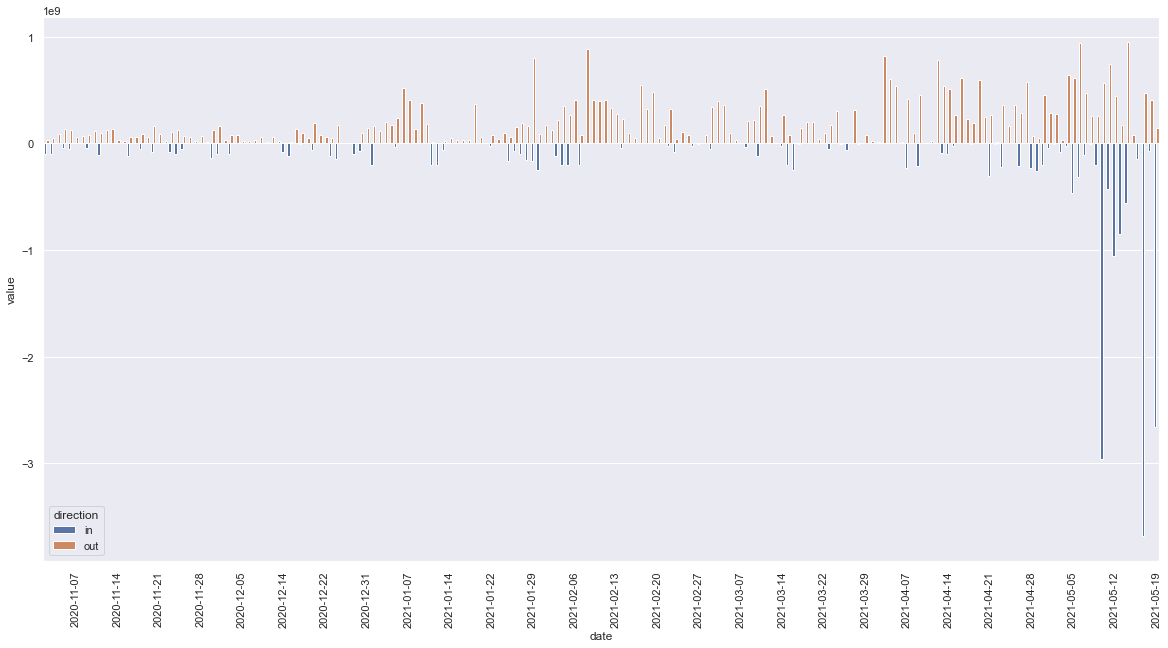

In [21]:
fig, ax = plt.subplots(figsize=(20,10))


sns.barplot(
    data=tt.loc[tt.date.astype(str) > '2020-11-01'],
    x="date", y='value', 
    hue="direction",
    ax=ax
)
ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday=1, interval=1))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
plt.show()

In [24]:
df.loc[(df.date >= '2021-05-13') & (df.direction == 'in')]

,date,value,token,from,to,chain,direction,day
1971,2021-05-13 00:13:10,-5.000000e+06,USDT,0xe11970f2f3de9d637fb786f2d869f8fea44195ac,tether scrambler eth,eth,in,2021-05-13
1972,2021-05-13 00:36:27,-1.500000e+08,USDT,bitfinex (tron),tether scrambler tron,tron,in,2021-05-13
1973,2021-05-13 00:37:15,-1.500000e+08,USDT,tether scrambler eth,bitfinex,eth,in,2021-05-13
1974,2021-05-13 00:56:57,-1.000000e+07,USDT,wallet 4 (large trader),tether scrambler eth,eth,in,2021-05-13
1975,2021-05-13 00:58:55,-2.500000e+07,USDT,0xe11970f2f3de9d637fb786f2d869f8fea44195ac,tether scrambler eth,eth,in,2021-05-13
1976,2021-05-13 02:01:27,-2.800000e+06,USDT,TWDchZBmYvTQBeXD4w8rRUowDv5ka8kiFU,tether scrambler tron,tron,in,2021-05-13
1980,2021-05-13 09:04:33,-1.000000e+08,USDT,binance,tether scrambler tron,tron,in,2021-05-13
1981,2021-05-13 10:24:33,-2.000000e+08,USDT,0x4862733b5fddfd35f35ea8ccf08f5045e57388b3,tether scrambler eth,eth,in,2021-05-13
1982,2021-05-13 11:42:40,-5.147852e+05,USDT,tether scrambler eth,0x376fa5c248eecb0110023efadd8317691b07ede1,eth,in,2021-05-13
1983,2021-05-13 12:56:24,-9.990000e-04,USDT,TALJj9RqzdNdRo6fcAVyzsitw1iAqxs53n,tether scrambler tron,tron,in,2021-05-13
